# Task 1: Symptom Co-occurrence Pattern Analysis (Apriori Algorithm)

**Objective:**  
Identify frequent symptom combinations that co-occur within the same disease profile, using the Apriori algorithm.

**Dataset:**  
Disease Symptom Prediction Dataset  
👉 [Kaggle Link](https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset)

**Method Summary:**
1. Load dataset and standardize column names  
2. Normalize symptom names (handle synonyms, spacing)  
3. Generate transactions (symptoms per disease)  
4. One-hot encode symptoms  
5. Run Apriori algorithm to find frequent itemsets  
6. Derive association rules (confidence, lift)  
7. Visualize and export results


In [4]:
import re
import os
from pathlib import Path
from collections.abc import Iterable

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

DATA_PATH = "../data/dataset.csv"
RESULTS_DIR = "../results/task1"
os.makedirs(RESULTS_DIR, exist_ok=True)

MIN_SUPPORT = 0.05
CONFIDENCE_THRESHOLD = 0.5

FREQUENT_ITEMSETS_PATH = f"{RESULTS_DIR}/frequent_symptom_sets.csv"
ASSOCIATION_RULES_PATH = f"{RESULTS_DIR}/association_rules.csv"


In [5]:
# Define synonym map
SYNONYM_MAP = {
    "belly_pain": "abdominal_pain",
    "stomach_pain": "abdominal_pain",
    "foul_smell_of_urine": "foul_smell_of_urine",
    "spotting_urination": "spotting_urination",
}

def load_dataset(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    print("✅ Original dataset preview:")
    display(df.head())
    df.columns = [c.strip() for c in df.columns]
    return df

df = load_dataset(DATA_PATH)


✅ Original dataset preview:


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def identify_symptom_columns(df: pd.DataFrame) -> list[str]:
    return [col for col in df.columns if "symptom" in col.lower()]

def normalize_symptom_name(raw: str) -> str:
    if not isinstance(raw, str):
        return ""
    symptom = re.sub(r"\s+", " ", raw.strip().lower())
    symptom = symptom.replace(" ", "_")
    symptom = re.sub(r"_+", "_", symptom)
    symptom = SYNONYM_MAP.get(symptom, symptom)
    return "" if symptom == "nan" else symptom

def normalize_symptom_columns(df: pd.DataFrame, columns: Iterable[str]) -> None:
    for col in columns:
        df[col] = df[col].astype(str).map(normalize_symptom_name)
    print("✅ After normalization (preview):")
    display(df.head())

symptom_columns = identify_symptom_columns(df)
normalize_symptom_columns(df, symptom_columns)


✅ After normalization (preview):


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic_patches,,,,,,,,,,,,,
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic_patches,,,,,,,,,,,,,,
2,Fungal infection,itching,nodal_skin_eruptions,dischromic_patches,,,,,,,,,,,,,,
3,Fungal infection,itching,skin_rash,dischromic_patches,,,,,,,,,,,,,,
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,,,,,,,,,,,,,,


In [7]:
def generate_transactions(df: pd.DataFrame, columns: Iterable[str]) -> list[list[str]]:
    transactions = []
    for _, row in df[list(columns)].iterrows():
        symptoms = [s for s in row.tolist() if s]
        symptoms = list(set(symptoms))
        if symptoms:
            transactions.append(symptoms)
    return transactions

transactions = generate_transactions(df, symptom_columns)
print("✅ Example transactions (first 5):")
for t in transactions[:5]:
    print(t)


✅ Example transactions (first 5):
['nodal_skin_eruptions', 'dischromic_patches', 'itching', 'skin_rash']
['nodal_skin_eruptions', 'dischromic_patches', 'skin_rash']
['nodal_skin_eruptions', 'dischromic_patches', 'itching']
['dischromic_patches', 'itching', 'skin_rash']
['nodal_skin_eruptions', 'itching', 'skin_rash']


In [8]:
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(encoded_array, columns=encoder.columns_)

print("✅ One-hot encoded matrix shape:", df_encoded.shape)
display(df_encoded.head())


✅ One-hot encoded matrix shape: (4920, 129)


,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,blackheads,bladder_discomfort,blister,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
frequent_itemsets = apriori(df_encoded, min_support=MIN_SUPPORT, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)

print("✅ Top 10 Frequent Symptom Sets:")
display(frequent_itemsets.head(10))


✅ Top 10 Frequent Symptom Sets:


,support,itemsets
10,0.392683,(fatigue)
27,0.389024,(vomiting)
12,0.276829,(high_fever)
0,0.256098,(abdominal_pain)
17,0.234146,(loss_of_appetite)
22,0.232927,(nausea)
11,0.230488,(headache)
38,0.198780,"(vomiting, abdominal_pain)"
128,0.198780,"(nausea, vomiting)"
81,0.198780,"(high_fever, fatigue)"


In [10]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=CONFIDENCE_THRESHOLD)
rules = rules.sort_values(by=["lift", "confidence"], ascending=[False, False])

print("✅ Top 10 Association Rules:")
display(rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10))


✅ Top 10 Association Rules:


,antecedents,consequents,support,confidence,lift
715,(phlegm),"(chest_pain, malaise)",0.069512,0.966102,13.658679
713,"(chest_pain, malaise)",(phlegm),0.069512,0.982759,13.658679
730,"(chest_pain, fatigue)",(phlegm),0.068293,0.982456,13.654475
734,"(chest_pain, chills)",(phlegm),0.068293,0.982456,13.654475
743,"(chest_pain, high_fever)",(phlegm),0.068293,0.982456,13.654475
732,(phlegm),"(chest_pain, fatigue)",0.068293,0.949153,13.654475
736,(phlegm),"(chest_pain, chills)",0.068293,0.949153,13.654475
746,(phlegm),"(chest_pain, high_fever)",0.068293,0.949153,13.654475
828,"(chest_pain, malaise, chills)",(phlegm),0.065854,0.981818,13.645609
840,"(chest_pain, high_fever, malaise)",(phlegm),0.065854,0.981818,13.645609


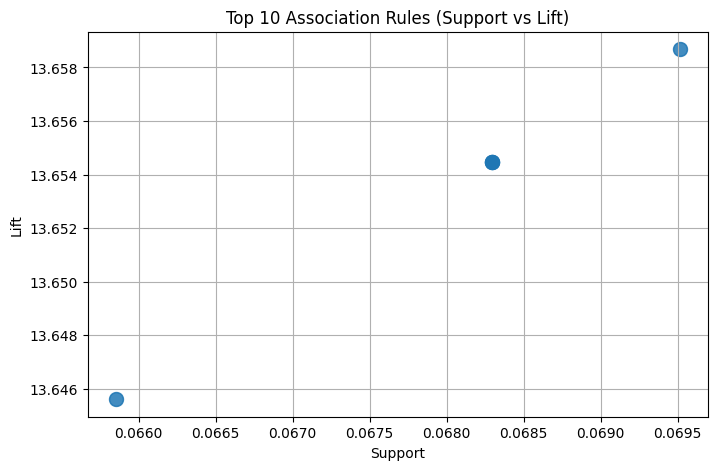

In [11]:
top_rules = rules.head(10)
plt.figure(figsize=(8, 5))
plt.scatter(top_rules["support"], top_rules["lift"], s=100, alpha=0.6)
plt.title("Top 10 Association Rules (Support vs Lift)")
plt.xlabel("Support")
plt.ylabel("Lift")
plt.grid(True)
plt.show()
